In [52]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import scanpy as sc
import scipy as sp

import sys 
import os
sys.path.append(os.path.abspath("./utility_functions"))

import rz_functions as rz
import ng_functions as ng
import rz_utility_spring as srz

from time import time
from seaborn import heatmap
from scipy import sparse

import scrublet as scr


In [53]:
cluster_annotation_dict =      {'0' : 'N4',
                                '1' : 'Mono_Trx1',
                                '2' : 'Mac1',
                                '3' : 'DC_CCR7+_CXCL9-',
                                '4' : 'N2',
                                '5' : 'DC_Trx1',
                                '6' : 'Th1',
                              'T5' : 'Th17',
                             'T17' : 'Tnaive',
                             'T31' : 'T8',
                                '7' : 'B_KLF2_hi',
                                '8' : 'EC1',
                                '9' : 'DC_Trx2',
                               '10' : 'KC',
                               '11' : 'NK',
                               '12' : 'KClike_MARCO-',
                               '13' : 'B_KLF2_lo',
                               '14' : 'NKT',
                               '15' : 'N3',
                              #'16' : 'Mono_NT',
                               '17' : 'DC_NT',
                               '18' : 'pDC',
                               '19' : 'Treg',
                               '20' : 'N1',
                               '21' : 'N5',
                               '22' : 'EC2',
                               '23' : 'Mono_Trx2', #placeholder
                               '24' : 'Basophils',
                               '25' : 'B3',
                               '26' : 'RBC',
                               '27' : 'Hepatocytes',
                               'Mono9' : 'Mono_CD11c-',
                                'Mono12' : 'Mono_CD14-',
                               'Myel15' : 'DC_S100A9+',
                               'Myel19' : 'DC_CD83_lo',
                               'Myel22' : 'KClike_MARCO+'}


coarse_annotation_dict =        {'B1' : 'B cells',
                                 'B2' : 'B cells',
                                 'B3' : 'B cells',
                                 'B_KLF2_hi' : 'B cells',
                                 'B_KLF2_lo' : 'B cells',
                                 'Basophils' : 'Basophils',
                                 'DC_CCR7+_CXCL9-' : 'MoMacDC',
                                 'DC_CD83_lo' : 'MoMacDC',
                                 'DC_NT' : 'MoMacDC',
                                 'DC_S100A9+' : 'MoMacDC',
                                 'DC1' : 'MoMacDC',
                                 'DC2' : 'MoMacDC',
                                 'DC3' : 'MoMacDC',
                                 'DC4' : 'MoMacDC',
                                 'DC_Trx1' : 'MoMacDC',
                                 'DC_Trx2' : 'MoMacDC',
                                 'Mac1' : 'MoMacDC',
                                 'Mac2' : 'MoMacDC',
                                 'Mac3' : 'MoMacDC',
                                 'Mac4' : 'MoMacDC',
                                 'CM' : 'MoMacDC',
                                 'iDC' : 'MoMacDC',
                                 'Mono_NT' : 'MoMacDC',
                                 'Mono_Trx1' : 'MoMacDC',
                                 'Mono_Trx2' : 'MoMacDC',
                                 'Mono_CD11c-' : 'MoMacDC',
                                 'Mono_CD14-' : 'MoMacDC',
                                 'MonoDC' : 'MoMacDC',
                                 'KC' : 'MoMacDC',
                                 'KClike_MARCO-' : 'MoMacDC',
                                 'KClike_MARCO+' : 'MoMacDC',
                                 'N1' : 'Neutrophils',
                                 'N2' : 'Neutrophils',
                                 'N3' : 'Neutrophils',
                                 'N4' : 'Neutrophils',
                                 'N5' : 'Neutrophils',
                                 'N6' : 'Neutrophils',
                                 'NK' : 'NK cells',
                                 'NKT' : 'T cells',
                                 'Th1' : 'T cells',
                                 'Th17' : 'T cells',
                                 'Tmix' : 'T cells',
                                 'T8' : 'T cells',
                                 'Tnaive' : 'T cells',
                                 'Treg' : 'T cells',
                                 'pDC' : 'pDC',
                                 'Hepatocytes' : 'Hepatocytes',
                                 'EC1' : 'Endothelial cells',
                                 'EC2' : 'Endothelial cells',
                                 'RBC' : 'Red blood cells'}

# Data loading, preprocessing and normalization

In [54]:
adata = sc.read_h5ad('backups/tox_marie_all_cells_unnormalized_pca_umap_leiden_35358x22631_backup_200512_04h53.h5ad') #coarse + fine + scrublet

adata[:,['Il12b']].X = adata[:,['Il12b', 'eYFP']].X.sum(1)
adata[:,['eYFP']].X = 0


sc.pp.normalize_total(adata, target_sum=1e4)

adata.obs['n_counts'] = adata.X.sum(1).A1

adata.obs.head()


,barcode,group,library_name,marker,max_mt,min_tot,mito_frac,n_counts,n_genes,pool,tissue,treatment,leiden,leiden2,doublet_score,predicted_doublet
48-pool1,AAACAAACAGAGGATAAGACACCA,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.040964,9999.998047,348,pool1,Liver,NT,8,7,0.007103,False
98-pool1,AAACAAACAGAGGATACAATACTT,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.005613,10000.000000,581,pool1,Liver,NT,20,32,0.014590,False
237-pool1,AAACAAACAGAGGATAGGCCCTTA,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.035451,9999.998047,470,pool1,Liver,NT,11,14,0.016036,False
246-pool1,AAACAAACAGAGGATAGGGAGGTA,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.018000,10000.000000,374,pool1,Liver,NT,Mono12,24,0.027342,False
342-pool1,AAACAAACAGAGGATATGGCTACC,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.035088,10000.000000,318,pool1,Liver,NT,T17,17,0.007778,False


In [55]:
#loglikelihoods = sp.sparse.load_npz('backups/loglikelihoods_bay_classif_tox_marie_all_cells_200407_11h02.npz')
logls = np.load('backups/loglikelihoods_bay_classif_tox_marie_all_cells_200407_11h02.npz', allow_pickle=True)

mostlikely_subset = pd.DataFrame(logls['data'], index=logls['index'], columns=logls['columns']).idxmax()
mostlikely_subset = pd.Series(mostlikely_subset, dtype='category')
mostlikely_subset.index = adata.obs.index

mostlikely_celltype = mostlikely_subset.map(ng.cell_subset_dict).astype('category')

In [86]:
adata.obs['cell_type'] = mostlikely_celltype
adata.obs['minor_subset'] = mostlikely_subset

#annotate color palette in adata.uns
#adata.uns['cell_type_colors'] = adata.obs['cell_type'].cat.categories.map(ng.cell_type_cmap).tolist()
#adata.uns['minor_subset_colors'] = adata.obs['minor_subset'].cat.categories.map(ng.cell_subset_cmap).tolist()

In [57]:
adata = adata[~(adata.obs.predicted_doublet)]
adata = adata[~adata.obs['leiden'].isin(['16', '28','29','30'])]

adata.obs['leiden_minor_subset'] = adata.obs.leiden.map(cluster_annotation_dict).astype('category')
adata.obs['leiden_cell_type'] = adata.obs.leiden_minor_subset.map(coarse_annotation_dict).astype('category')


Trying to set attribute `.obs` of view, copying.


In [58]:
adata_il12b = adata[adata.obs.leiden.isin(['3','5', '9', '12', 'Myel15', 'Myel22', 'Myel19'])]

In [203]:
vdg_df = pd.read_excel('Van_de_Garde_PLOS_2016/journal.pone.0166094.s003.XLSX', skiprows=2).set_index('Gene')
vdg_df.columns = ['KC0a', 'KC0b', 'KC15', 'KC22', 'KC41', 'Mono0a', 'Mono0b', 'Mono15', 'Mono22', 'Mono41']
vdg_df = 10000 * vdg_df.div(vdg_df.sum(axis=0), axis=1)

In [240]:
vdg_obs = pd.DataFrame({'id' : vdg_df.T.index, 'sample_id' : vdg_df.T.index}, vdg_df.T.index)
#vdg_obs.columns = ['sample']

In [242]:
vdg_gene_list = pd.DataFrame(vdg_df.T.columns).set_index('Gene')#.set_index('gene_symbol')
#vdg_gene_list.columns = ['gene_symbol']

In [243]:
vdgdata = sc.AnnData(X=vdg_df.T.values,
           obs=vdg_obs,
           var = vdg_gene_list)

In [326]:
vdg_df

,KC0a,KC0b,KC15,KC22,KC41,Mono0a,Mono0b,Mono15,Mono22,Mono41
Gene,,,,,,,,,,
Abcb10,0.458422,0.682096,0.027616,0.542114,0.289833,0.934470,1.150680,0.625414,0.328887,0.352068
Abcb1a,0.373529,0.423370,0.000000,0.148932,0.000000,1.007762,0.516632,0.000000,0.000000,0.387275
Abcf1,4.176734,4.704111,4.252922,3.091835,3.933443,5.460236,5.142837,3.152597,4.966190,6.372432
Abl1,6.621651,6.962085,3.811060,4.110532,4.071459,4.232599,4.485305,1.582680,1.644434,3.133406
Adal,0.764037,1.317151,0.220931,0.697003,0.345039,0.714595,0.727981,0.280798,0.000000,0.140827
...,...,...,...,...,...,...,...,...,...,...
Xcl1,4.210691,3.504563,0.165698,0.208505,0.151817,3.820333,2.911926,0.153163,0.493330,0.668929
Xcr1,5.110556,1.411233,0.000000,0.089359,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Zap70,2.003474,1.011384,1.132271,0.804234,0.027603,3.233999,0.751465,0.548833,0.822217,0.844963


In [300]:
cat0 = #rz.centroids('leiden_minor_subset', adata)

In [357]:
cat0 = vdg_df
cat0.index.name = None

In [359]:
pseudo = 0.1
cat = cat0 + pseudo

# Find common genes between the two datasets.
 Filtering on variable genes is also a possibility but I start by simply using all genes

In [360]:
Eraw = adata.X
print(type(Eraw))

gene_list = adata.var_names

<class 'scipy.sparse.csr.csr_matrix'>


In [361]:
# common genes
gmask = np.in1d(gene_list, cat.index)

# genes detected in the current dataset:
m2 = np.array(Eraw.sum(axis=0))[0]>0

# combine masks
gmask = gmask&m2


common_genes = gene_list[gmask]
print(len(gene_list),len(cat.index),len(common_genes))

22631 547 512


In [362]:
print(Eraw.shape)

(34659, 22631)


In [363]:
start = time()
bays = []
i = 0
step=5000
comment = 'marie_tox_classified_on_vdg_profiles'
for j in range(step,Eraw.shape[0]+step,step):
    
    # Eraw - sparse cells x gene matrix
    j = min(j,Eraw.shape[0])
    tmp_dense = pd.DataFrame(Eraw.T[gmask][:,i:j].todense())
    tmp_dense.index = np.array(gene_list)[gmask]
    
    bay = rz.bayesian_classifier(tmp_dense,cat.loc[common_genes])
    bays.append(bay)
    i0 = i
    i = j
    
    print('%.2f min.'%((time()-start)/60.))
    print('cells from %d to %d done'%(i0,j))

# conenate
bay = pd.concat(bays,axis=1)

# reset index
bay.columns = np.arange(bay.shape[1])

fname = 'backups/loglikelihoods_bay_classif_%s_%s'%(comment,rz.now())
print(fname)
rz.save_df(bay,fname)

0.06 min.
cells from 0 to 5000 done
0.11 min.
cells from 5000 to 10000 done
0.16 min.
cells from 10000 to 15000 done
0.22 min.
cells from 15000 to 20000 done
0.27 min.
cells from 20000 to 25000 done
0.32 min.
cells from 25000 to 30000 done
0.37 min.
cells from 30000 to 34659 done
backups/loglikelihoods_bay_classif_marie_tox_classified_on_vdg_profiles_200526_01h13


In [364]:
#??rz.bayesian_classifier

In [367]:
logls_vdg = np.load('backups/loglikelihoods_bay_classif_marie_tox_classified_on_vdg_profiles_200526_01h13.npz', allow_pickle=True)

mostlikely_vdg = pd.DataFrame(logls_vdg['data'], index=logls_vdg['index'], columns=logls_vdg['columns']).idxmax()
mostlikely_vdg = pd.Series(mostlikely_vdg, dtype='category')
mostlikely_vdg.index = adata.obs.index

adata.obs['vdg_subset'] = mostlikely_vdg

#mostlikely_celltype = mostlikely_subset.map(ng.cell_subset_dict).astype('category')

[<Figure size 1374x400 with 2 Axes>]

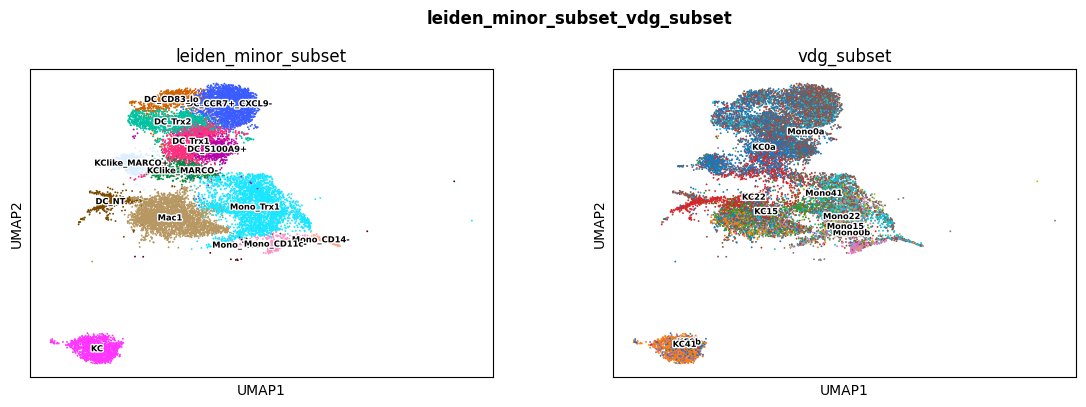

In [370]:
#pd.DataFrame(logls['data'], index=logls['index'], columns=logls['columns'])
ng.umap_plot(adata, filt='leiden_cell_type == "MoMacDC"', color=['leiden_minor_subset','vdg_subset'])

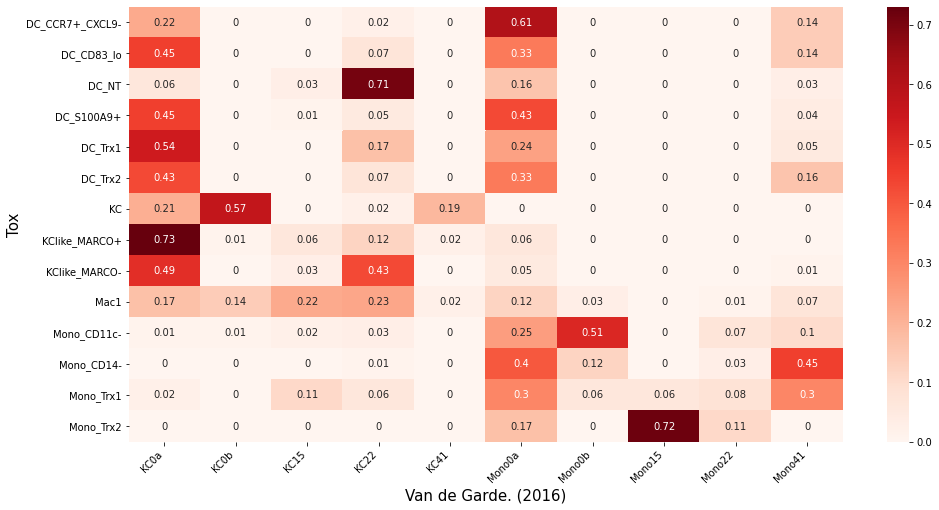

In [379]:
tox_to_vdg = adata.obs.query('leiden_cell_type == "MoMacDC"').groupby(['leiden_minor_subset', 'vdg_subset']).size().groupby(level=0).apply(lambda x : x/sum(x)).reset_index(name='fraction').pivot(columns='leiden_minor_subset', index='vdg_subset')
tox_to_vdg.columns = tox_to_vdg.columns.get_level_values('leiden_minor_subset')
tox_to_vdg = tox_to_vdg[sorted(tox_to_vdg)].dropna(1)


#tox_to_rz_subset.index.get_level_values('leiden_minor_subset')
plt.figure(figsize=(16,8))
heatmap(round(tox_to_vdg.transpose(),2), annot=True, cmap='Reds')

plt.xlabel('Van de Garde. (2016)', fontsize=15)
plt.ylabel('Tox', fontsize=15)
plt.xticks(rotation=45, horizontalalignment="right")


plt.show()

#round(tox_to_rz_subset.transpose(),2).index.get_level_values('leiden_minor_subset')

# Load reference expression profiles in an AnnData object compatible with scanpy¶

In [16]:
go_df = pd.read_csv('Gal-Oz_NatCommun_2018/GSE122108_Normalized_Gene_count_table.csv', index_col='gene_symbol').T
go_df.index.rename('cell_id', inplace=True)

In [17]:
#go_df.index[70]

In [18]:
go_gene_list = pd.DataFrame(go_df.columns).set_index('gene_symbol')

In [19]:
godata = sc.AnnData(X=go_df.values,
                    obs=go_df.index,
                   var=go_gene_list)

godata.var_names_make_unique()


sc.pp.normalize_per_cell(godata, counts_per_cell_after=1e4)
godata.X = sparse.coo_matrix(godata.X)


print(godata.shape)
godata.obs.head()

(412, 52997)


,cell_id,n_counts
0,MF.64pLYVEpIIn.Ao.1,6760442.0
1,MF.64pLYVEpIIn.Ao.2,7174790.5
2,MF.64pLYVEpIIn.Ao.3,6764147.5
3,MF.64pLYVEpIIp.Ao.1,6989994.0
4,MF.64pLYVEpIIp.Ao.2,7080953.0


In [21]:
godata.obs.cell_id.str.split('.')

godata.obs['Cell_type'] = [i[0] for i in godata.obs.cell_id.str.split('.')]
godata.obs['Metadata'] = ['.'.join(i[1:-2]) for i in godata.obs.cell_id.str.split('.')]
godata.obs['Organ'] = [i[-2] for i in godata.obs.cell_id.str.split('.')]
godata.obs['Batch'] = [i[-1] for i in godata.obs.cell_id.str.split('.')]

In [52]:
#save counts column into a npz df quickly accessible for SPRING

!mkdir -p spring
srz.save_counts_for_spring(godata,'spring/gal-oz_{}'.format(rz.now()), tot_count_column='n_counts')

print(rz.now())

saving for quick loading of genes...
saving for quick loading of cells...
saving as npz...
done
200520_01h50


# Make a SPRING plot using all cells

In [42]:
# out of all cells in adata, select only those you want to plot
# make a copy of the adata object

godata.X = godata.X.tocsc()


cell_mask = np.repeat(True,godata.shape[0])
cdata = godata[cell_mask].copy() # all cells in this case

# chose a name for the spring subplot
plot_name = 'all_cells_w_dblt_corr'

# chose dataset for selecting abundant and variable genes
# here I use linear counts-per-10k

E = cdata.X

# in an attempt to be more organized I keep a log of spring parameter and intermediate data structures used in
# the form of an unstructured annotation as part of an AnnData object.

srz.start_spring_params(cdata,plot_name)

# print the newly created dictionary, also define a variable to access it faster:
pdict = cdata.uns['spring_params'][plot_name]
pdict

{'k': 5,
 'cell_mask': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True

In [43]:
# prepath = 'Gal-Oz_NatCommun_2018/'
# # load count data
# rzdata = sc.read_mtx(prepath+'GSE122108_Normalized_Gene_count_table.csv')

# # load cell annotations
# rzdata.obs = pd.read_csv(prepath+'GSE127465_mouse_cell_metadata_15939x12.tsv.gz',
#             sep='\t',comment='#')

# # load gene names
# rzdata.var_names = np.loadtxt(prepath+'GSE127465_gene_names_mouse_28205.tsv.gz',dtype=str)
# rzdata.var_names_make_unique()

# #normalize immunity paper data to 10,000 counts per cell
# sc.pp.normalize_per_cell(rzdata,counts_per_cell_after=1e4)

# print(rzdata.shape)
# rzdata.obs.head()

In [44]:
# avoid genes starting with
toavoid = ['mt-','Rps','Rpl','Mrpl','Mrps']
# for i in toavoid:
#     print(i)
#     print([g for g in godata.var_names if g.startswith(i)])
#     print()
#     print()

In [45]:
np.array((E>=pdict['min_counts']).sum(axis=0))[0]>=pdict['min_cells']

array([False, False, False, ...,  True, False, False])

In [46]:

cell_mask = np.repeat(True,godata.shape[0])


pdict = dict()


pdict['cell_mask'] = cell_mask # record which cell out of all were used

pdict['k'] = 10

pdict['min_counts'] = 10
pdict['min_cells'] = 5


E = godata.X

# genes to exclude:


exclude_gene_names = []
for j in toavoid:
    exclude_gene_names.append([i for i in godata.var_names if i.startswith(j)])
exclude_gene_names = rz.flatten_list_of_lists(exclude_gene_names)

pdict['gene_names_excluded'] = exclude_gene_names
print('%d genes excluded based on name'%len(exclude_gene_names))


##########################################################################################

# filter on abundance:
pdict['abundant_gene_mask'] = srz.filter_abund_genes(
                                                     E,
                                                     pdict['min_counts'],
                                                     pdict['min_cells']
                                                    )

509 genes excluded based on name
557 genes passing abundance filter


In [47]:
# combine gene filters so far
undesired = list(pdict['gene_names_excluded'])+\
            list(cdata.var_names[~pdict['abundant_gene_mask']])

print(len(undesired))
undesired = list(set(undesired))
print(len(undesired))

# boolean mask
combmask = ~np.in1d(cdata.var_names,undesired)
print(combmask.sum(),'surviving genes so far')

52949
52457
540 surviving genes so far


In [48]:
# calculate v score (Klein et al., 2015, see equation S4 and S13) for all non-zero genes
isexpr = np.array(E.sum(axis=0))[0]>0
print('%d genes with non-zero expression'%sum(isexpr))
pdict['v_score_dict'] = srz.vscores(E[:,isexpr])

52997 genes with non-zero expression


In [49]:
# get genes above mode, i.e. any that can be considered variable
gabmod = cdata.var_names[isexpr][pdict['v_score_dict']['var_gene_mask']]
print(len(gabmod),'variable genes')

52997 variable genes


In [50]:
# update combmask:
mvar = np.in1d(cdata.var_names,gabmod)
print(mvar.sum())
combmask = combmask&mvar
print(combmask.sum(),'abundant and variable genes')

52997
540 abundant and variable genes


In [51]:
# if filtering on correlation, get gene-gene correlation (quite slow)
corx = E[:,combmask]
print(corx.shape)
corx = srz.sparse_corrcoef(corx.T)
corx = np.array(corx)

(412, 540)
0.01 min.


In [52]:
# select correlation filters (largely arbitrary), as described in Klein et al. 2015
genes_at_least = 3 #at least this number of genes correlated to any other gene
corr_at_least = 0.15 #with a Pearson correlation coefficient at least this large

################################################################################

# genes passing correlation filter
cormask = (abs(corx)>corr_at_least).sum(axis=0)>genes_at_least #"more than" as one instance is the gene itself with r=1
print((~cormask).sum(), 'genes to exclude based on correlation')

# combine filter
pdict['genes_used'] = cdata.var_names[combmask][cormask]
print(len(pdict['genes_used']),'genes surviving all filters')

0 genes to exclude based on correlation
540 genes surviving all filters


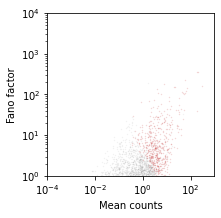

In [53]:
# plot a fano factor vs mean plot with genes used further colored in red
ff = pdict['v_score_dict']['ff_gene']
mu = pdict['v_score_dict']['mu_gene']
finalmask = np.in1d(cdata.var_names,pdict['genes_used'])

# check scatter
s = 2
plt.figure(figsize=(3,3))
plt.scatter(mu,ff,lw=0,color='0.5',alpha=0.1,s=s)
plt.scatter(mu[finalmask[isexpr]],ff[finalmask[isexpr]],lw=0,color='r',alpha=0.1,s=s)
plt.xscale('log');
plt.yscale('log');
plt.xlim(0.0001,1000)
plt.ylim(1,10000)
plt.xlabel('Mean counts')
plt.ylabel('Fano factor');

# Prepare data for PCA

In [54]:
# leave only genes defined as variable, overwrite
print(cdata.shape)
finalmask = np.in1d(cdata.var_names,pdict['genes_used'])
cdata = cdata[:,finalmask]
print(cdata.shape)

(412, 52997)
(412, 540)


In [55]:
sc.pp.scale(cdata)
Z = cdata.X

/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:912: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


# PCA using automatically computed number of components. Skip to next block for manually computed number of PCs.

In [56]:
# find the number of non-random PCs. Shuffling 3 times would be enough here for the initial plot.
d = srz.find_num_pc(Z,start_pc=500,sparse=False,n=5)

calculating the first 411 observed eigenvalues...
calculating the random eigenvalues for 5 rounds of shuffling...
1 	 20 	 0.01 min.
2 	 20 	 0.01 min.
3 	 20 	 0.02 min.
4 	 20 	 0.02 min.
5 	 20 	 0.02 min.


### Run PCA on the z-scored data


In [57]:
start = time()

#here's where one could adjust the number of PCs to set it automatically from the previous cell
sc.tl.pca(cdata, svd_solver='arpack', n_comps = d['num_pc'],) 

print(time() - start)

0.010752201080322266


# Compute neighbors map of cells, necessary for UMAP

In [58]:
sc.pp.neighbors(cdata, n_neighbors=10, use_rep='X_pca')

In [59]:
sc.tl.umap(cdata)

# Classifier

# GO cluster characterization

In [88]:
cat0 = rz.centroids('leiden_minor_subset', adata).T
cat0.head()

,EC1,N1,NK,Mono_CD14-,Tnaive,DC_CCR7+_CXCL9-,N4,Th1,B_KLF2_hi,KC,...,B3,KClike_MARCO-,T8,Hepatocytes,DC_Trx1,Basophils,DC_CD83_lo,RBC,Mono_Trx2,DC_Trx2
Xkr4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.332447,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Rp1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Sox17,0.842714,0.000000,0.000000,0.000000,0.000000,0.000000,0.003524,0.020247,0.000000,0.000000,...,0.000000,0.000000,0.054299,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Mrpl15,0.405819,0.000000,0.338068,0.324636,0.766301,0.574795,0.055832,0.457622,0.584114,0.245774,...,1.552626,0.365676,0.638389,3.280503,0.498485,0.367278,0.495037,0.0,0.308471,0.310509
Lypla1,0.702126,0.250964,0.661918,0.582624,0.471754,0.533167,0.301729,0.663823,0.362715,0.351326,...,0.934806,0.603201,0.761356,0.679124,0.617957,0.891293,0.764077,0.0,2.336199,0.468392


In [12]:
pseudo = 0.1
cat = cat0 + pseudo

# Find common genes between the two datasets.
 Filtering on variable genes is also a possibility but I start by simply using all genes

In [ ]:
Eraw = godata.X
print(type(Eraw))

gene_list = godata.var_names

In [ ]:
# common genes
gmask = np.in1d(gene_list, cat.index)

# genes detected in the current dataset:
m2 = np.array(Eraw.sum(axis=0))[0]>0

# combine masks
gmask = gmask&m2


common_genes = gene_list[gmask]
print(len(gene_list),len(cat.index),len(common_genes))

In [ ]:
print(Eraw.shape)

In [101]:
start = time()
bays = []
i = 0
step=5000
comment = 'gal-oz_classified_on_ng_clusters'
for j in range(step,Eraw.shape[0]+step,step):
    
    # Eraw - sparse cells x gene matrix
    j = min(j,Eraw.shape[0])
    tmp_dense = pd.DataFrame(Eraw.T[gmask][:,i:j])#.todense())
    tmp_dense.index = np.array(gene_list)[gmask]
    
    bay = rz.bayesian_classifier(tmp_dense,cat.loc[common_genes])
    bays.append(bay)
    i0 = i
    i = j
    
    print('%.2f min.'%((time()-start)/60.))
    print('cells from %d to %d done'%(i0,j))

# conenate
bay = pd.concat(bays,axis=1)

# reset index
bay.columns = np.arange(bay.shape[1])

fname = 'backups/loglikelihoods_bay_classif_%s_%s'%(comment,rz.now())
print(fname)
rz.save_df(bay,fname)

0.22 min.
cells from 0 to 412 done
backups/loglikelihoods_bay_classif_gal-oz_classified_on_ng_clusters_200519_01h40


# GO cluster characterization (by only IL12b+ groups)

In [22]:
cat0 = rz.centroids('leiden_minor_subset', adata_il12b).T
cat0.head()

,DC_CCR7+_CXCL9-,KClike_MARCO+,DC_S100A9+,KClike_MARCO-,DC_Trx1,DC_CD83_lo,DC_Trx2
Xkr4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Rp1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sox17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mrpl15,0.574795,0.271996,0.477275,0.365676,0.498485,0.495037,0.310509
Lypla1,0.533167,0.550605,0.819667,0.603201,0.617957,0.764077,0.468392


In [23]:
pseudo = 0.1
cat = cat0 + pseudo

# Find common genes between the two datasets.
 Filtering on variable genes is also a possibility but I start by simply using all genes

In [24]:
Eraw = godata.X
print(type(Eraw))

gene_list = godata.var_names

<class 'scipy.sparse.coo.coo_matrix'>


In [25]:
# common genes
gmask = np.in1d(gene_list, cat.index)

# genes detected in the current dataset:
m2 = np.array(Eraw.sum(axis=0))[0]>0

# combine masks
gmask = gmask&m2


common_genes = gene_list[gmask]
print(len(gene_list),len(cat.index),len(common_genes))

52997 22631 22000


In [37]:
print(Eraw.shape)

(412, 52997)


In [39]:
Eraw.T.todense()[gmask]

matrix([[0.16318144, 0.16266184, 0.10573571, ..., 0.13699389, 0.13424978,
         0.14038433],
        [0.21473868, 0.19457947, 0.21703747, ..., 0.2964732 , 0.37994787,
         0.36993217],
        [0.00850973, 0.02995165, 0.02965604, ..., 0.01244811, 0.01299619,
         0.01109875],
        ...,
        [1.2833797 , 0.9421241 , 1.0665938 , ..., 1.8821535 , 1.986558  ,
         2.2947042 ],
        [0.57329583, 0.52551496, 0.5748937 , ..., 0.8478161 , 1.1441646 ,
         0.91477853],
        [0.23348676, 0.19625933, 0.21281083, ..., 0.3374822 , 0.33846638,
         0.43721345]], dtype=float32)

In [40]:
start = time()
bays = []
i = 0
step=5000
comment = 'gal-oz_classified_on_ng_il12b_clusters'
for j in range(step,Eraw.shape[0]+step,step):
    
    # Eraw - sparse cells x gene matrix
    j = min(j,Eraw.shape[0])
    tmp_dense = pd.DataFrame(Eraw.T.todense()[gmask][:,i:j])#.todense())
    tmp_dense.index = np.array(gene_list)[gmask]
    
    bay = rz.bayesian_classifier(tmp_dense,cat.loc[common_genes])
    bays.append(bay)
    i0 = i
    i = j
    
    print('%.2f min.'%((time()-start)/60.))
    print('cells from %d to %d done'%(i0,j))

# conenate
bay = pd.concat(bays,axis=1)

# reset index
bay.columns = np.arange(bay.shape[1])

fname = 'backups/loglikelihoods_bay_classif_%s_%s'%(comment,rz.now())
print(fname)
rz.save_df(bay,fname)

0.06 min.
cells from 0 to 412 done
backups/loglikelihoods_bay_classif_gal-oz_classified_on_ng_il12b_clusters_200520_23h56


# Remember to update the NPZ file in the line below!!!! ⚠️

# Load classifier log-likelihoods, distinguish from Lung --> Tox

In [60]:
logls_galoz = np.load('backups/loglikelihoods_bay_classif_gal-oz_classified_on_ng_clusters_200519_01h40.npz', allow_pickle=True)

mostlikely_subset_galoz = pd.DataFrame(logls_galoz['data'], index=logls_galoz['index'], columns=logls_galoz['columns']).idxmax()
mostlikely_subset_galoz = pd.Series(mostlikely_subset_galoz, dtype='category')
mostlikely_subset_galoz.index = godata.obs.index

mostlikely_celltype_galoz = mostlikely_subset_galoz.map(coarse_annotation_dict).astype('category')

godata.obs['leiden_cell_type'] = mostlikely_celltype_galoz
godata.obs['leiden_minor_subset'] = mostlikely_subset_galoz
cdata.obs['leiden_cell_type'] = mostlikely_celltype_galoz
cdata.obs['leiden_minor_subset'] = mostlikely_subset_galoz

In [61]:
logls_galoz_il12b = np.load('backups/loglikelihoods_bay_classif_gal-oz_classified_on_ng_il12b_clusters_200520_23h56.npz', allow_pickle=True)

mostlikely_subset_galoz_il12b = pd.DataFrame(logls_galoz_il12b['data'], index=logls_galoz_il12b['index'], columns=logls_galoz_il12b['columns']).idxmax()
mostlikely_subset_galoz_il12b = pd.Series(mostlikely_subset_galoz_il12b, dtype='category')
mostlikely_subset_galoz_il12b.index = godata.obs.index

mostlikely_celltype_galoz_il12b = mostlikely_subset_galoz_il12b.map(coarse_annotation_dict).astype('category')

godata.obs['leiden_cell_type_il12b'] = mostlikely_celltype_galoz_il12b
godata.obs['leiden_minor_subset_il12b'] = mostlikely_subset_galoz_il12b
cdata.obs['leiden_cell_type_il12b'] = mostlikely_celltype_galoz_il12b
cdata.obs['leiden_minor_subset_il12b'] = mostlikely_subset_galoz_il12b

In [74]:
cdata.obs['KC'] = cdata.obs.Metadata.str.contains('KC')#.astype('category')
cdata.obs['pDC'] = cdata.obs.Metadata.str.contains('pDC')#.astype('category')
cdata.obs['cDC1'] = cdata.obs.Metadata.str.contains('cDC1')#.astype('category')
cdata.obs['cDC2'] = cdata.obs.Metadata.str.contains('cDC2')#.astype('category')

In [63]:
#cdata.obs.Metadata.str.contains

In [112]:
godata.obs.leiden_cell_type.cat.categories

#np.where(rzdata.obs.leiden_minor_subset.map(coarse_annotation_dict).astype('category').isna())
#rzdata.obs.iloc[[ 305, 4746, 9669, 9820, 9842, 9863],:]

Index(['B cells', 'Endothelial cells', 'MoMacDC', 'pDC'], dtype='object')

In [70]:
cdata.obs[(cdata.obs.Organ == 'Lv')].loc[:,['cell_id', 'Cell_type', 'Organ', 'leiden_minor_subset', 'leiden_minor_subset_il12b']]

,cell_id,Cell_type,Organ,leiden_minor_subset,leiden_minor_subset_il12b
127,MF.64p6Cn6Gn.E18.5.Lv.1,MF,Lv,KC,KClike_MARCO+
128,MF.64p6Cn6Gn.E18.5.Lv.2,MF,Lv,KC,KClike_MARCO+
152,DC.cDC1.XCR1p.Lv.1,DC,Lv,DC_NT,KClike_MARCO-
153,DC.cDC1.XCR1p.Lv.2,DC,Lv,DC_NT,KClike_MARCO-
154,DC.cDC1.XCR1p.Lv.3,DC,Lv,DC_NT,KClike_MARCO-
155,DC.cDC2.172ap.Lv.1,DC,Lv,DC_NT,KClike_MARCO-
156,DC.cDC2.172ap.Lv.2,DC,Lv,DC_NT,KClike_MARCO-
157,DC.cDC2.172ap.Lv.3,DC,Lv,DC_NT,KClike_MARCO-
158,DC.cDC2.172ap.Lv.4,DC,Lv,DC_NT,KClike_MARCO-
159,DC.pDC.120g8p11cintp6Cp.Lv.1,DC,Lv,pDC,DC_S100A9+


Trying to set attribute `.obs` of view, copying.
... storing 'Cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Metadata' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Organ' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Batch' as categorical


[<Figure size 6870x8000 with 12 Axes>]

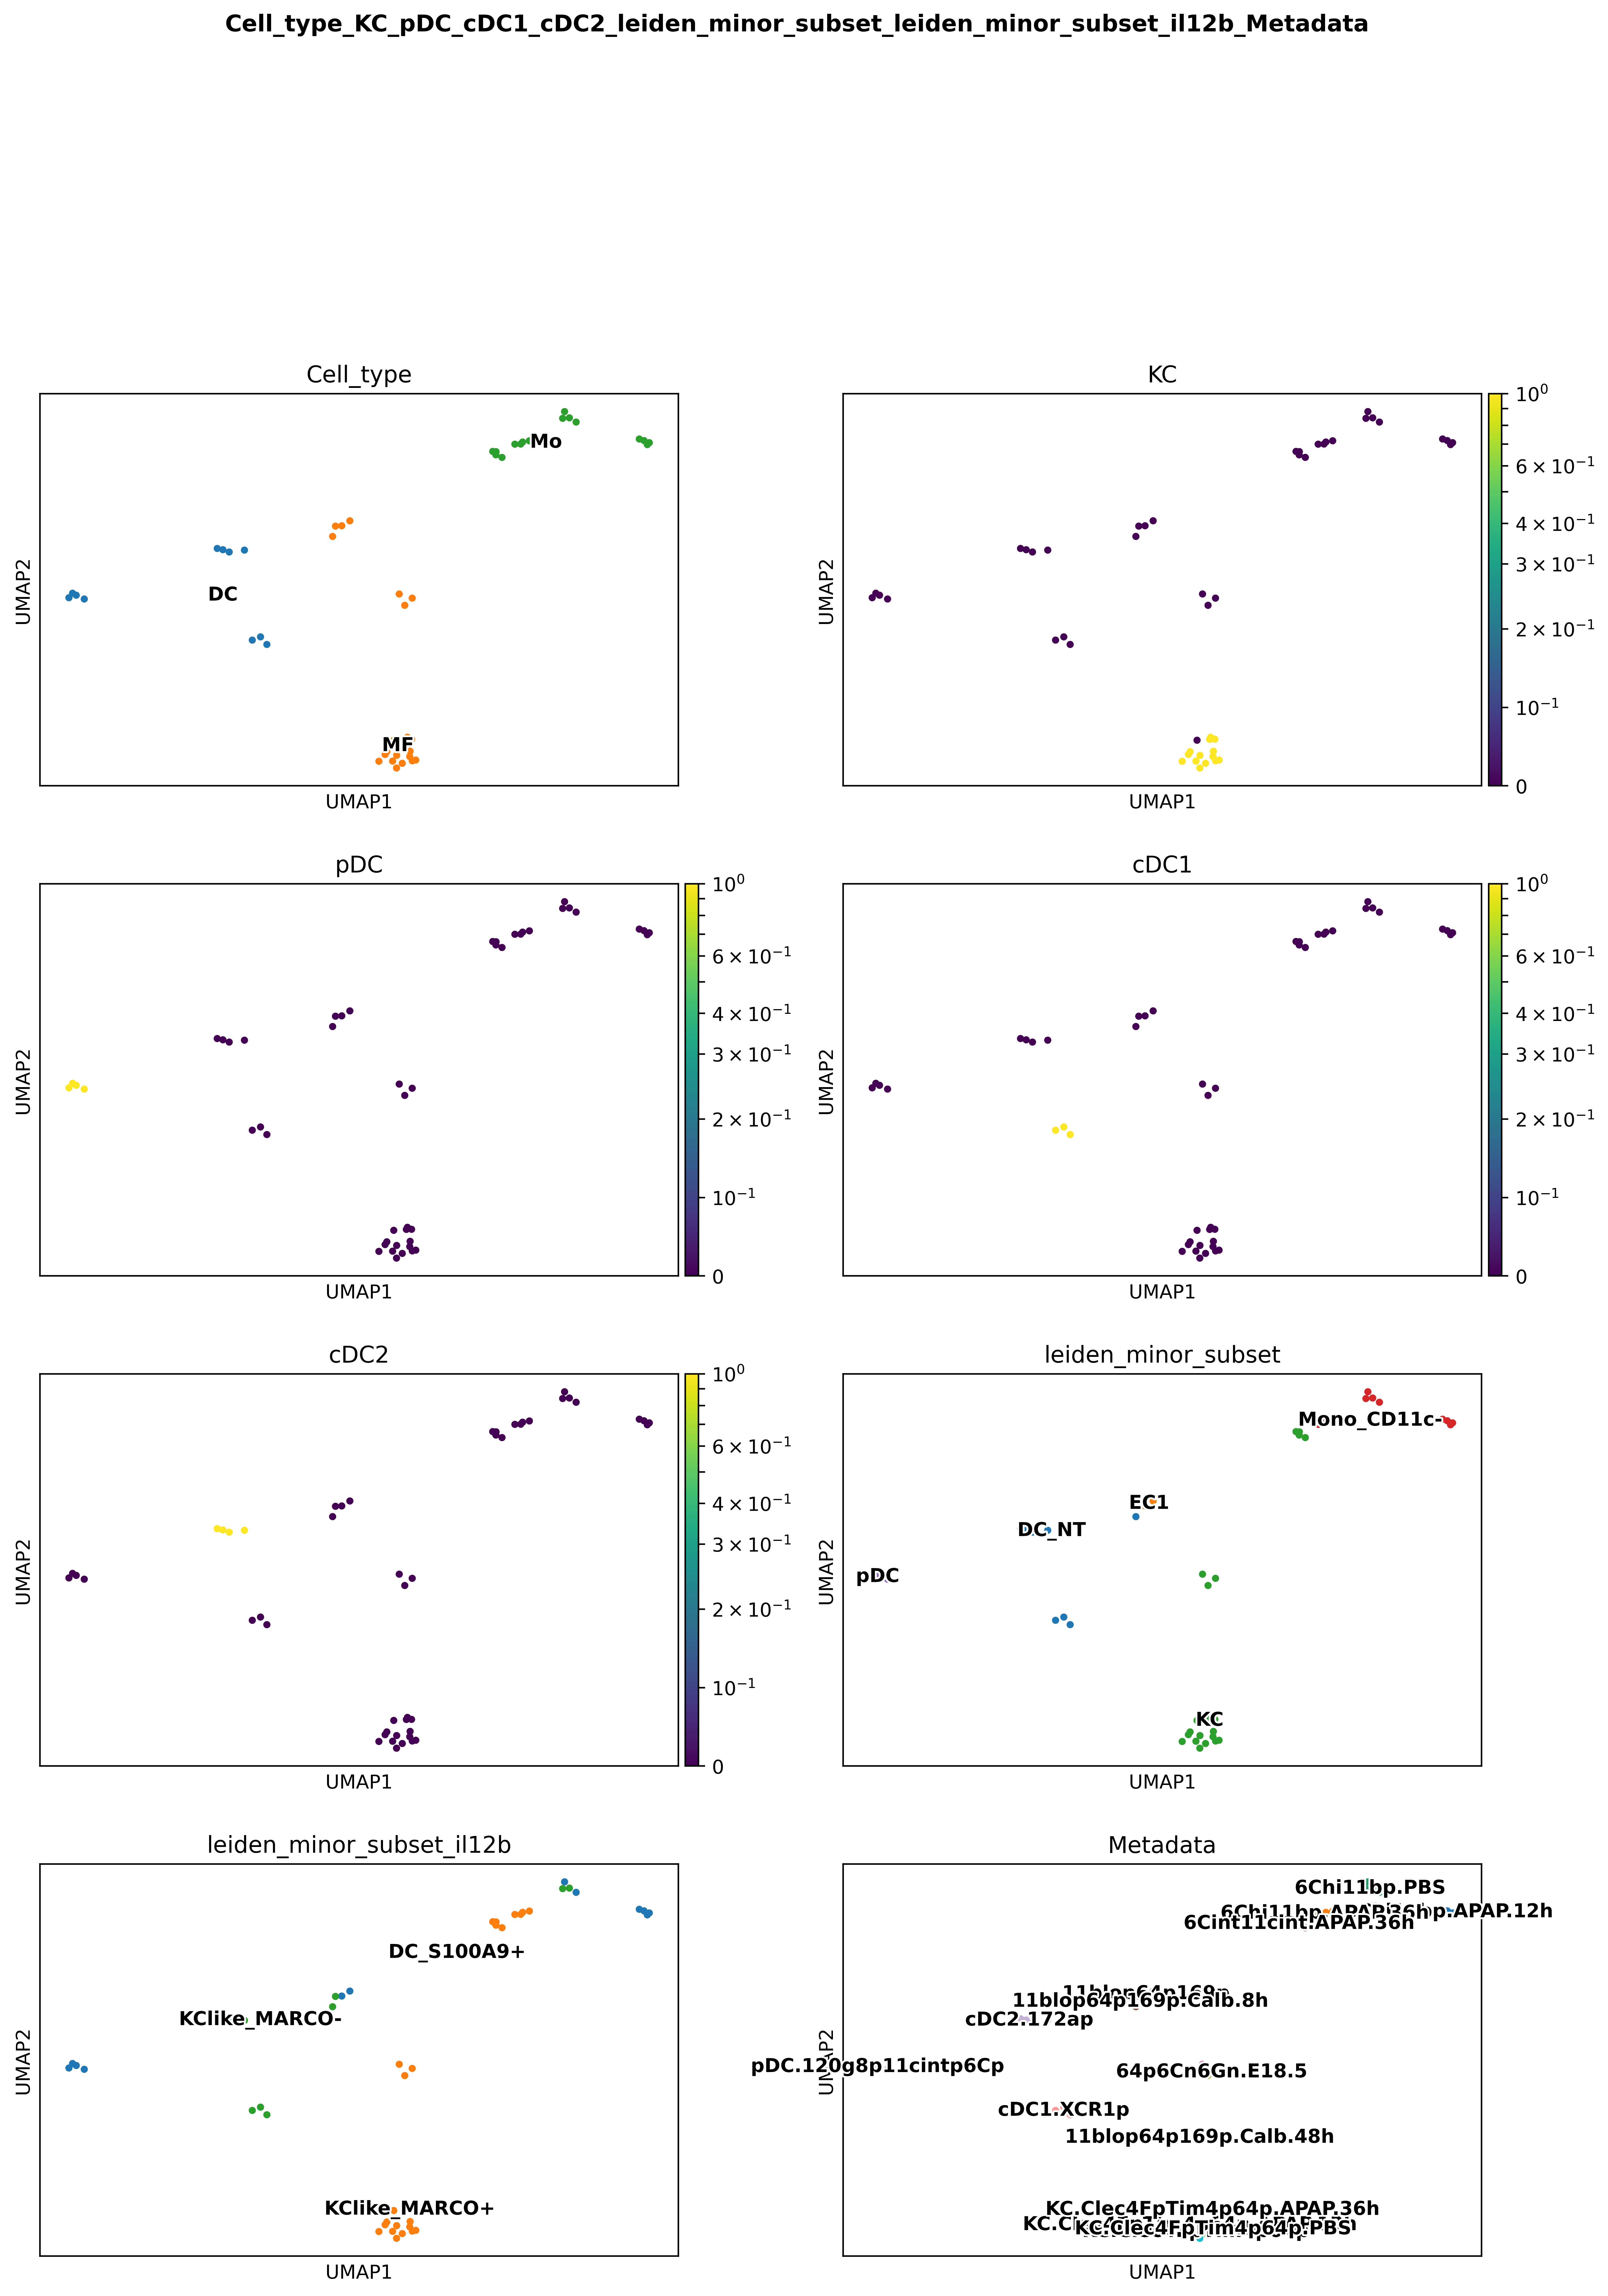

In [75]:
ng.umap_plot(cdata, color=['Cell_type', 'KC','pDC', 'cDC1', 'cDC2', 'leiden_minor_subset', 'leiden_minor_subset_il12b', 'Metadata'], filt='Organ == "Lv"', dpi_show=500, legend_fontsize=10, size=56, ncols=2)

In [80]:
godata

AnnData object with n_obs × n_vars = 412 × 52997 
    obs: 'n_counts', 'leiden_cell_type', 'leiden_minor_subset'

In [83]:
go_df.index

Index(['MF.64pLYVEpIIn.Ao.1', 'MF.64pLYVEpIIn.Ao.2', 'MF.64pLYVEpIIn.Ao.3',
       'MF.64pLYVEpIIp.Ao.1', 'MF.64pLYVEpIIp.Ao.2', 'MF.64pLYVEpIIp.Ao.3',
       'MF.64pLYVEnIIp.Ao.1', 'MF.64pLYVEnIIp.Ao.2', 'MF.64pLYVEnIIp.Ao.3',
       'MF.PC.44',
       ...
       'MF.B220n6Cn64pTim4p.PC.2', 'MF.B220n6Cn64pTim4p.PC.3',
       'MF.B220n6Cn64pTim4p.PC.4', 'MF.B220n6Cn64pTim4p.PC.5',
       'MF.B220n6Cn64pTim4p.PC.6', 'MF.PC.11', 'MF.PC.12', 'MF.PC.13',
       'MF.PC.14', 'MF.PC.15'],
      dtype='object', name='cell_id', length=412)

# Major cell type level

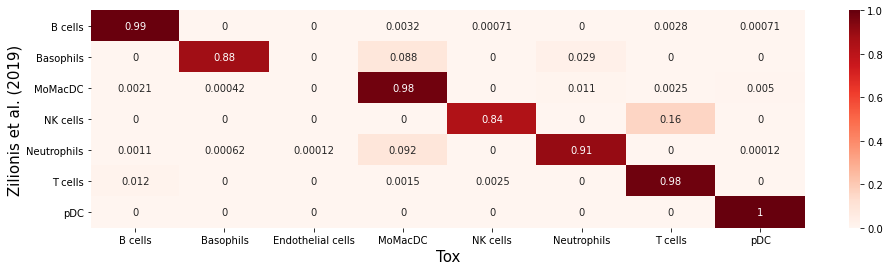

In [37]:
rz_to_tox_cell_type = rzdata.obs.groupby(['Major cell type', 'leiden_cell_type']).size().groupby(level=0).apply(lambda x : x/sum(x)).reset_index(name='fraction').pivot(index='Major cell type', columns='leiden_cell_type')
rz_to_tox_cell_type.columns = rz_to_tox_cell_type.columns.get_level_values('leiden_cell_type')


plt.figure(figsize=(16,4))
heatmap(rz_to_tox_cell_type, annot=True, cmap='Reds')

plt.ylabel('Zilionis et al. (2019)', fontsize=15)
plt.xlabel('Tox', fontsize=15)
#plt.xticks(rotation=45)


plt.show()

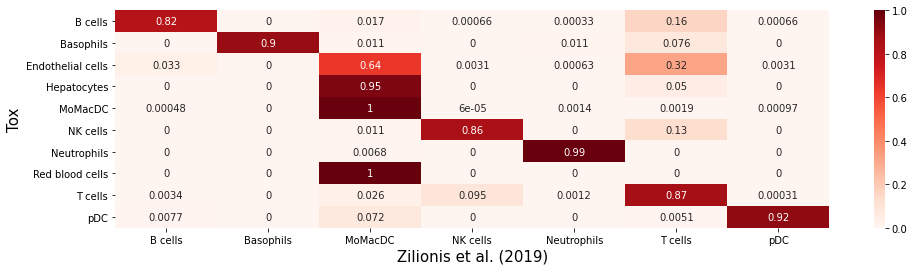

In [38]:
tox_to_rz_cell_type = adata.obs.groupby(['leiden_cell_type', 'cell_type']).size().groupby(level=0).apply(lambda x : x/sum(x)).reset_index(name='fraction').pivot(columns='leiden_cell_type', index='cell_type')
tox_to_rz_cell_type.columns = tox_to_rz_cell_type.columns.get_level_values('leiden_cell_type')


plt.figure(figsize=(16,4))

#transpose to keep direction of axes and still make it multiplicable
heatmap(tox_to_rz_cell_type.transpose(), annot=True, cmap='Reds')

plt.xlabel('Zilionis et al. (2019)', fontsize=15)
plt.ylabel('Tox', fontsize=15)

plt.show()

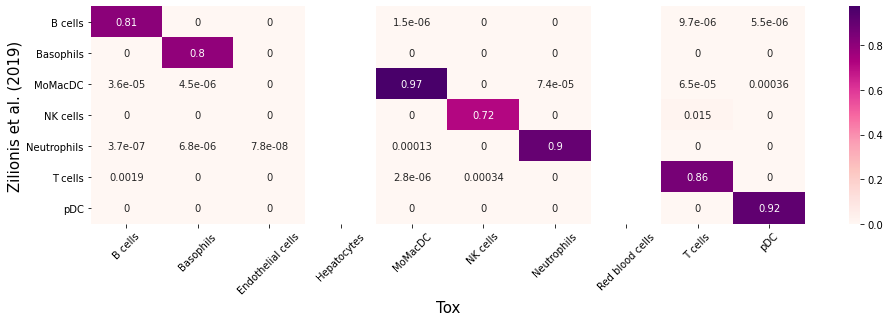

In [39]:
reciprocal_cell_type = rz_to_tox_cell_type * tox_to_rz_cell_type

plt.figure(figsize=(16,4))
heatmap(reciprocal_cell_type, annot=True, cmap='RdPu')

plt.ylabel('Zilionis et al. (2019)', fontsize=15)
plt.xlabel('Tox', fontsize=15)
plt.xticks(rotation=45)

plt.show()

# Minor subset level

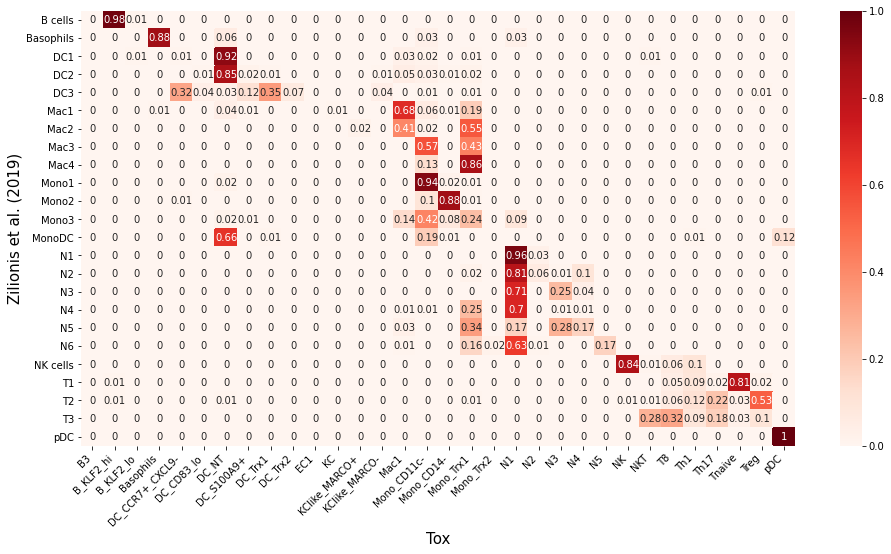

In [40]:
rz_to_tox_subset = rzdata.obs.groupby(['Minor subset', 'leiden_minor_subset']).size().groupby(level=0).apply(lambda x : x/sum(x)).reset_index(name='fraction').pivot(index='Minor subset', columns='leiden_minor_subset')
rz_to_tox_subset.columns = rz_to_tox_subset.columns.get_level_values('leiden_minor_subset')

plt.figure(figsize=(16,8))
heatmap(round(rz_to_tox_subset,2), annot=True, cmap='Reds')

plt.ylabel('Zilionis et al. (2019)', fontsize=15)
plt.xlabel('Tox', fontsize=15)
plt.xticks(rotation=45, horizontalalignment="right")

plt.show()

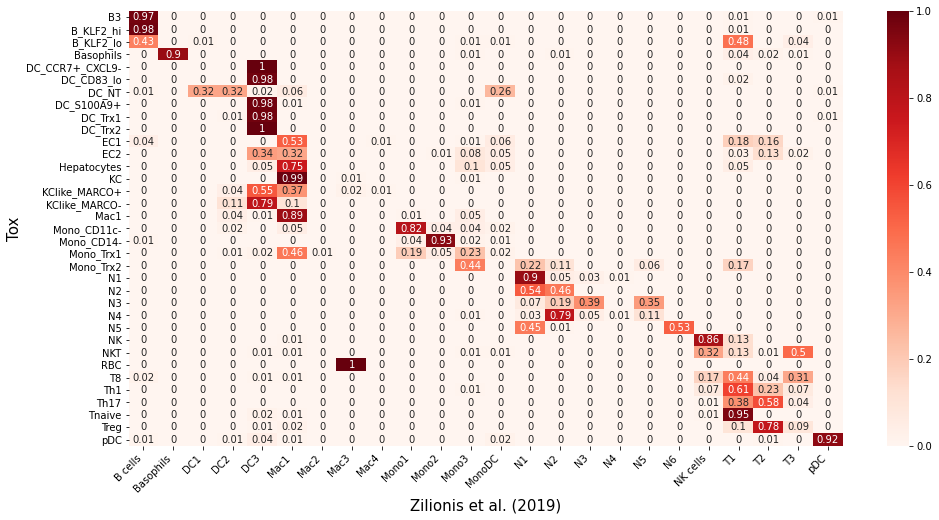

In [44]:
tox_to_rz_subset = adata.obs.groupby(['leiden_minor_subset', 'minor_subset']).size().groupby(level=0).apply(lambda x : x/sum(x)).reset_index(name='fraction').pivot(columns='leiden_minor_subset', index='minor_subset')
tox_to_rz_subset.columns = tox_to_rz_subset.columns.get_level_values('leiden_minor_subset')
tox_to_rz_subset = tox_to_rz_subset[sorted(tox_to_rz_subset)]


#tox_to_rz_subset.index.get_level_values('leiden_minor_subset')
plt.figure(figsize=(16,8))
heatmap(round(tox_to_rz_subset.transpose(),2), annot=True, cmap='Reds')

plt.xlabel('Zilionis et al. (2019)', fontsize=15)
plt.ylabel('Tox', fontsize=15)
plt.xticks(rotation=45, horizontalalignment="right")


plt.show()

#round(tox_to_rz_subset.transpose(),2).index.get_level_values('leiden_minor_subset')

In [45]:
tox_to_rz_subset.columns

CategoricalIndex(['B3', 'B_KLF2_hi', 'B_KLF2_lo', 'Basophils',
                  'DC_CCR7+_CXCL9-', 'DC_CD83_lo', 'DC_NT', 'DC_S100A9+',
                  'DC_Trx1', 'DC_Trx2', 'EC1', 'EC2', 'Hepatocytes', 'KC',
                  'KClike_MARCO+', 'KClike_MARCO-', 'Mac1', 'Mono_CD11c-',
                  'Mono_CD14-', 'Mono_Trx1', 'Mono_Trx2', 'N1', 'N2', 'N3',
                  'N4', 'N5', 'NK', 'NKT', 'RBC', 'T8', 'Th1', 'Th17',
                  'Tnaive', 'Treg', 'pDC'],
                 categories=['N4', 'Mono_Trx1', 'KC', 'NK', 'KClike_MARCO-', 'B_KLF2_lo', 'NKT', 'N3', ...], ordered=False, name='leiden_minor_subset', dtype='category')

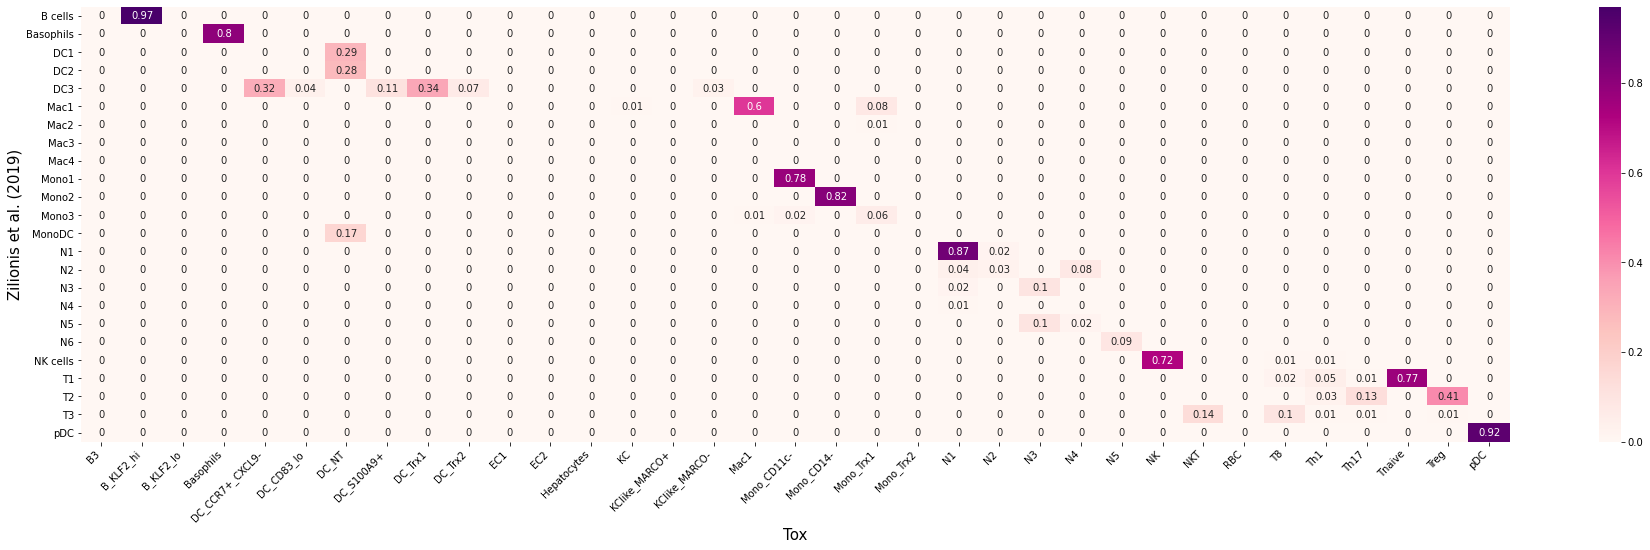

In [46]:
reciprocal_subset = rz_to_tox_subset * tox_to_rz_subset

plt.figure(figsize=(32,8))
heatmap(round(reciprocal_subset.fillna(0),2), annot=True, cmap='RdPu')

plt.ylabel('Zilionis et al. (2019)', fontsize=15)
plt.xlabel('Tox', fontsize=15)
plt.xticks(rotation=45, ha='right')
#plt.gca().xaxis.set_tick_params(ha='left')

plt.show()
